In [1]:
#pip install wrds

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wrds
import psycopg2
import statsmodels.api as sm
from tqdm.notebook import tqdm

In [3]:
db = wrds.Connection(wrds_username="thomas_bienaime")
#db.create_pgpass_file()

Loading library list...
Done


# Question a)

In [4]:
# we download the stocks returns 
stocks_returns_raw = db.raw_sql("""
                      select  a.permno, a.date,
                      a.ret, a.prc , a.shrout ,  a.hsiccd
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2021'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

#we download the risk free rate
risk_free=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1990-01-01'"
            "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])
risk_free = risk_free.rename(
    columns ={"mcaldt" : "date", "tmytm" :"risk_free" })
risk_free = risk_free.set_index("date")
# downlad index returns
market_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1990-01-01'"
            "and date<='2021-12-31'", date_cols=['date'])
market_index = market_index.set_index("date")
#we tranform the returns of the risk free rate
risk_free['risk_free']=np.exp(risk_free['risk_free']/(12*100))-1

In [5]:
stocks_returns_raw["date"] = stocks_returns_raw["date"].dt.to_period('M')
risk_free = risk_free.to_period('M')
market_index = market_index.to_period('M')

In [6]:
number_observations=stocks_returns_raw.groupby(by=["permno"]).count()
stocks_returns_pemno_384= number_observations[number_observations["ret"]>=384].index.sort_values()
stocks_returns_raw_clean = stocks_returns_raw.loc[stocks_returns_raw["permno"].isin(stocks_returns_pemno_384) ]
display(stocks_returns_raw_clean)

,permno,date,ret,prc,shrout,hsiccd
6854,10516.0,1990-01,-0.134054,20.000000,281065.0,2046.0
6855,10516.0,1990-02,0.050000,21.000000,281065.0,2046.0
6856,10516.0,1990-03,0.083333,22.750000,283801.0,2046.0
6857,10516.0,1990-04,0.034066,23.500000,283801.0,2046.0
6858,10516.0,1990-05,0.127660,26.500000,283801.0,2046.0
...,...,...,...,...,...,...
102726,85914.0,2021-08,0.037027,116.510002,245964.0,5731.0
102727,85914.0,2021-09,-0.086688,105.709999,245964.0,5731.0
102728,85914.0,2021-10,0.156371,122.239998,245964.0,5731.0
102729,85914.0,2021-11,-0.125818,106.860001,245964.0,5731.0


# Question b)

In [7]:
stocks_returns_raw_clean["Market Cap"] = np.abs(stocks_returns_raw_clean["prc"] * stocks_returns_raw_clean["shrout"])
stocks_returns_dec_2021 =stocks_returns_raw_clean[stocks_returns_raw_clean["date"]=="2021-12-31"]
stocks_returns_dec_2021 = stocks_returns_dec_2021.sort_values('Market Cap' , ascending = True).set_index("permno")
display(stocks_returns_dec_2021)
stocks_returns_pemno = list(stocks_returns_dec_2021.index)

/home/thomas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,ret,prc,shrout,hsiccd,Market Cap
permno,,,,,,
13769.0,2021-12,-0.088391,2.370000,5868.0,7352.0,1.390716e+04
30509.0,2021-12,0.030132,26.275000,966.0,3452.0,2.538165e+04
42358.0,2021-12,0.159363,2.910000,9446.0,1311.0,2.748786e+04
50243.0,2021-12,-0.005100,12.680000,2492.0,3728.0,3.159856e+04
31691.0,2021-12,-0.034654,14.209900,2703.0,3679.0,3.840936e+04
...,...,...,...,...,...,...
18163.0,2021-12,0.131415,163.580002,2419948.0,2844.0,3.958551e+08
55976.0,2021-12,0.032781,144.690002,2773878.0,5311.0,4.013524e+08
66181.0,2021-12,0.040064,415.010010,1044239.0,5211.0,4.333696e+08


In [8]:
risk_free = risk_free.sort_index()
stocks_ret_matrix = pd.DataFrame(index = risk_free.index, data = risk_free)
stocks_ret_matrix = pd.merge(stocks_ret_matrix, market_index, left_index=True, right_index= True, suffixes=("",""))

for permno in tqdm(stocks_returns_pemno):
    display()
    stocks_ret_matrix = pd.merge(stocks_ret_matrix,
                stocks_returns_raw[stocks_returns_raw["permno"]==permno]
                                .set_index("date")["ret"].rename( permno ),
                left_index = True, right_index = True, suffixes=("",""))
    
display(stocks_ret_matrix)

  0%|          | 0/328 [00:00<?, ?it/s]

,risk_free,vwretd,13769.0,30509.0,42358.0,50243.0,31691.0,49138.0,29058.0,54244.0,...,50876.0,17778.0,26403.0,21936.0,59408.0,18163.0,55976.0,66181.0,22111.0,47896.0
date,,,,,,,,,,,,,,,,,,,,,
1990-01,0.006390,-0.070114,-0.185185,-0.028902,-0.037545,-0.150000,-0.054422,-0.144144,0.041667,-0.111111,...,-0.078467,-0.140634,-0.069241,-0.014388,-0.091892,-0.082562,-0.050139,-0.040956,-0.117895,-0.138075
1990-02,0.006441,0.014900,0.090909,0.076786,-0.255639,0.176471,-0.035971,0.095789,-0.080000,0.750000,...,-0.037069,-0.030852,0.051621,-0.129927,0.067857,-0.001953,0.032258,0.132527,0.029403,-0.004854
1990-03,0.006688,0.024148,0.250000,0.030812,0.265657,0.225000,-0.037313,0.217391,0.000000,0.428571,...,0.070393,-0.069204,0.014840,0.027542,-0.129213,0.060665,0.075455,0.150943,0.046620,-0.061268
1990-04,0.006283,-0.028283,-0.216667,-0.019231,-0.084000,0.020408,-0.038760,-0.059524,-0.086957,0.050000,...,0.023211,-0.003717,-0.004319,-0.063918,-0.019355,0.049077,0.050265,0.021858,0.008909,0.000000
1990-05,0.006132,0.088935,0.021277,0.010644,-0.027948,-0.120000,0.169355,0.207595,0.142857,0.000000,...,0.189565,0.067164,0.167421,0.171366,0.028947,0.169912,0.136020,0.296791,0.134040,0.171123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.000034,0.027147,0.003521,-0.035622,0.060345,0.320649,-0.047777,-0.273874,0.056357,-0.207006,...,0.064230,0.026259,0.029997,0.076150,0.088373,0.001125,0.042792,-0.006125,0.011556,0.053828
2021-09,0.000038,-0.042243,-0.031579,0.042324,0.231707,0.027434,0.013937,0.066998,0.217047,0.071486,...,-0.105463,-0.043082,-0.066906,-0.066421,0.021796,-0.018189,-0.058879,0.011435,-0.067175,0.023382
2021-10,0.000042,0.064657,0.057971,0.001116,-0.158416,-0.025840,0.039863,-0.108140,-0.074486,0.096327,...,0.102618,0.052319,-0.000591,0.016973,0.125559,0.029040,0.072033,0.132456,0.008545,0.043986


In [9]:
#Separate the dataFrame into the 10 quantile
group1 = stocks_returns_dec_2021.iloc[:33]
group2 = stocks_returns_dec_2021.iloc[33:66]
group3 = stocks_returns_dec_2021.iloc[66:99]
group4 = stocks_returns_dec_2021.iloc[99:132]
group5 = stocks_returns_dec_2021.iloc[132:165]
group6 = stocks_returns_dec_2021.iloc[165:198]
group7 = stocks_returns_dec_2021.iloc[198:231]
group8 = stocks_returns_dec_2021.iloc[231:264]
group9 = stocks_returns_dec_2021.iloc[264:296]
group10 = stocks_returns_dec_2021.iloc[296:]

In [10]:
def permno_group(group):
    liste_permno = []
    liste_permno = list(group.index)
    return liste_permno

In [11]:
# put all data into a dataframe indexed by their permno and date, and each return is on the right date
risk_free = risk_free.sort_index()
def DataFrame_group_return(liste_group):
    stocks_ret_matrix = pd.DataFrame(index = risk_free.index, data = risk_free)
    stocks_ret_matrix = pd.merge(stocks_ret_matrix, market_index, left_index=True, right_index= True, suffixes=("",""))
    stocks_marketcap_matrix = pd.DataFrame(index = risk_free.index)
    for permno in liste_group:
        display()
        stocks_ret_matrix = pd.merge(stocks_ret_matrix,
                  stocks_returns_raw_clean[stocks_returns_raw_clean["permno"]==permno]
                                 .set_index("date")["ret"].rename( permno ),
                  left_index = True, right_index = True, suffixes=("",""))
        
        stocks_marketcap_matrix = pd.merge(stocks_marketcap_matrix , 
                                           stocks_returns_raw_clean[stocks_returns_raw_clean["permno"] == permno]
                                           .set_index("date")["Market Cap"].rename( permno ),
                                            left_index = True, right_index = True, suffixes=("",""))
    
    return stocks_ret_matrix , stocks_marketcap_matrix

In [12]:
test1, test2 = DataFrame_group_return(permno_group(group1))
display(test1)

,risk_free,vwretd,13769.0,30509.0,42358.0,50243.0,31691.0,49138.0,29058.0,54244.0,...,13303.0,75649.0,50606.0,57007.0,47511.0,63132.0,68830.0,34497.0,50550.0,40440.0
date,,,,,,,,,,,,,,,,,,,,,
1990-01,0.006390,-0.070114,-0.185185,-0.028902,-0.037545,-0.150000,-0.054422,-0.144144,0.041667,-0.111111,...,-0.107692,-0.244094,-0.086957,-0.014205,-0.130980,-0.200000,0.103448,-0.069307,-0.161871,0.120130
1990-02,0.006441,0.014900,0.090909,0.076786,-0.255639,0.176471,-0.035971,0.095789,-0.080000,0.750000,...,-0.017241,0.041667,0.066667,-0.043228,0.056818,0.375000,-0.062500,0.084397,0.075536,0.040580
1990-03,0.006688,0.024148,0.250000,0.030812,0.265657,0.225000,-0.037313,0.217391,0.000000,0.428571,...,-0.139181,0.104800,0.008929,0.123494,-0.005376,-0.060606,-0.133333,0.119454,0.028112,0.025281
1990-04,0.006283,-0.028283,-0.216667,-0.019231,-0.084000,0.020408,-0.038760,-0.059524,-0.086957,0.050000,...,-0.068493,-0.109091,-0.017699,-0.056300,-0.003892,0.000000,0.038462,-0.057927,-0.179688,-0.109589
1990-05,0.006132,0.088935,0.021277,0.010644,-0.027948,-0.120000,0.169355,0.207595,0.142857,0.000000,...,0.066176,0.030612,0.279279,-0.016477,-0.021858,0.225806,-0.148148,0.126214,-0.182857,0.089231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.000034,0.027147,0.003521,-0.035622,0.060345,0.320649,-0.047777,-0.273874,0.056357,-0.207006,...,0.134328,0.016067,0.015901,0.054306,-0.018209,-0.023170,0.033659,-0.134121,0.024876,0.045149
2021-09,0.000038,-0.042243,-0.031579,0.042324,0.231707,0.027434,0.013937,0.066998,0.217047,0.071486,...,-0.149123,-0.073795,0.048696,-0.075962,-0.028851,-0.044592,-0.057692,-0.017477,-0.099861,-0.070772
2021-10,0.000042,0.064657,0.057971,0.001116,-0.158416,-0.025840,0.039863,-0.108140,-0.074486,0.096327,...,0.001736,-0.009852,0.005804,0.025338,0.018037,-0.038927,0.101164,0.013036,0.049307,-0.109792


In [13]:
def equally_weighted(group):
    #Begin by computing the return at each date
    Return = pd.DataFrame(index = risk_free.index , data = risk_free)
    ret , _ = DataFrame_group_return(permno_group(group))
    Return["Return"] = ret.drop(["risk_free","vwretd"],axis=1).mean(axis = 1)
    Return["Excess Return"] = Return["Return"] - stocks_ret_matrix["risk_free"]
    Return["Market Premium"] = stocks_ret_matrix["vwretd"] - stocks_ret_matrix["risk_free"]
    avg_ret = Return["Excess Return"].mean()
    print(f"The the sample average excess return of these decile is : {avg_ret:.2%}")

    model = sm.OLS(Return["Excess Return"] , sm.add_constant(Return["Market Premium"]) )
    results = model.fit()
    alpha = results.params["const"]
    beta = results.params["Market Premium"]
    print(f"The the sample corresponding alpha is : {alpha:.2%}")
    print(f"The the sample corresponding beta is : {beta:.4}")
    
    return avg_ret,alpha,beta

In [14]:
def value_weighted(group):
    #Begin by computing the return at each date
    Return = pd.DataFrame(index = risk_free.index[1:] , data = risk_free[1:])
    ret , mkt_cap = DataFrame_group_return(permno_group(group))
    weight = pd.DataFrame(index = risk_free.index[1:] , columns = permno_group(group))
    for date in ret.index[:-1]:
        weight.loc[date+1] = mkt_cap.loc[date] / mkt_cap.loc[date].sum()
    Return["Return"]  = (weight * ret.drop(["risk_free","vwretd"],axis=1)[1:]).sum(axis = 1)
    Return["Excess Return"] = Return["Return"] - stocks_ret_matrix["risk_free"][1:]
    Return["Market Premium"] = stocks_ret_matrix["vwretd"][1:] - stocks_ret_matrix["risk_free"][1:]
    
    avg_ret = Return["Excess Return"].mean()
    print(f"The the sample average excess return of these decile is : {avg_ret:.2%}")
    
    model = sm.OLS(Return["Excess Return"] , sm.add_constant(Return["Market Premium"]) )
    results = model.fit()
    alpha = results.params["const"]
    beta = results.params["Market Premium"]
    print(f"The the sample corresponding alpha is : {alpha:.2%}")
    print(f"The the sample corresponding beta is : {beta:.4}")
    
    return avg_ret,alpha,beta

In [15]:
Avg_Returns_EW = []
Alphas_EW = []
Betas_EW = []

Avg_Returns_VW = []
Alphas_VW = []
Betas_VW = []

# b_Decile 1

In [16]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group1)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group1)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 1.00%
The the sample corresponding alpha is : 0.29%
The the sample corresponding beta is : 0.9937
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.21%
The the sample corresponding alpha is : -0.65%
The the sample corresponding beta is : 1.165


# b_Decile 2

In [17]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group2)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group2)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.96%
The the sample corresponding alpha is : 0.15%
The the sample corresponding beta is : 1.138
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.31%
The the sample corresponding alpha is : -0.46%
The the sample corresponding beta is : 1.045


# b_Decile 3

In [18]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group3)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group3)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.96%
The the sample corresponding alpha is : 0.21%
The the sample corresponding beta is : 1.046
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.54%
The the sample corresponding alpha is : -0.26%
The the sample corresponding beta is : 1.069


# b_Decile 4

In [19]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group4)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group4)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 1.01%
The the sample corresponding alpha is : 0.33%
The the sample corresponding beta is : 0.9521
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.56%
The the sample corresponding alpha is : -0.15%
The the sample corresponding beta is : 0.9528


# b_Decile 5

In [20]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group5)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group5)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 1.10%
The the sample corresponding alpha is : 0.36%
The the sample corresponding beta is : 1.02
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.70%
The the sample corresponding alpha is : -0.04%
The the sample corresponding beta is : 1.008


# b_Decile 6

In [21]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group6)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group6)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.94%
The the sample corresponding alpha is : 0.24%
The the sample corresponding beta is : 0.9701
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.60%
The the sample corresponding alpha is : -0.13%
The the sample corresponding beta is : 0.9904


# b_Decile 7

In [22]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group7)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group7)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 1.00%
The the sample corresponding alpha is : 0.39%
The the sample corresponding beta is : 0.846
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.62%
The the sample corresponding alpha is : 0.03%
The the sample corresponding beta is : 0.7977


# b_Decile 8

In [23]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group8)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group8)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 1.00%
The the sample corresponding alpha is : 0.39%
The the sample corresponding beta is : 0.8475
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.67%
The the sample corresponding alpha is : -0.02%
The the sample corresponding beta is : 0.9253


# b_Decile 9

In [24]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group9)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group9)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 1.06%
The the sample corresponding alpha is : 0.46%
The the sample corresponding beta is : 0.8307
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.83%
The the sample corresponding alpha is : 0.18%
The the sample corresponding beta is : 0.8836


# b_Decile 10

In [25]:
print("For the Equally Weighted Portfolio, we obtain the following results:")
a,b,c = equally_weighted(group10)
Avg_Returns_EW.append(a)
Alphas_EW.append(b)
Betas_EW.append(c)

print("For the Value Weighted Portfolio, we obtain the following results:")
a,b,c = value_weighted(group10)
Avg_Returns_VW.append(a)
Alphas_VW.append(b)
Betas_VW.append(c)

For the Equally Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.98%
The the sample corresponding alpha is : 0.36%
The the sample corresponding beta is : 0.861
For the Value Weighted Portfolio, we obtain the following results:
The the sample average excess return of these decile is : 0.77%
The the sample corresponding alpha is : 0.21%
The the sample corresponding beta is : 0.7641


# Plot the Equally Weighted Results

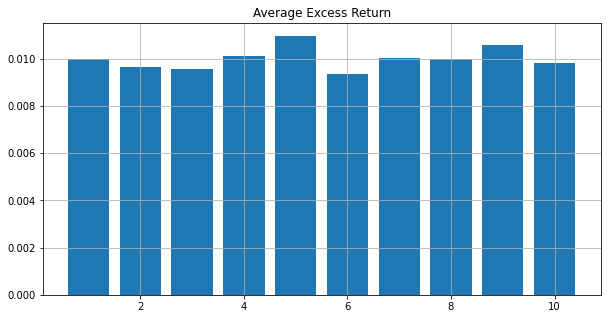

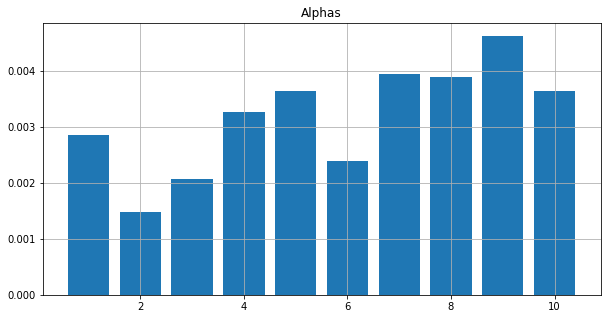

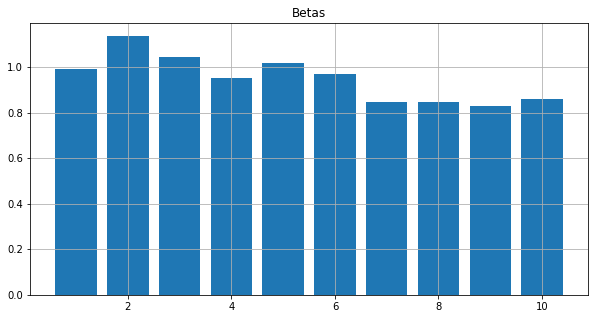

In [26]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Avg_Returns_EW )
plt.title("Average Excess Return")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Alphas_EW )
plt.title("Alphas")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Betas_EW )
plt.title("Betas")
plt.grid()

# Plot the Value Weighted Results

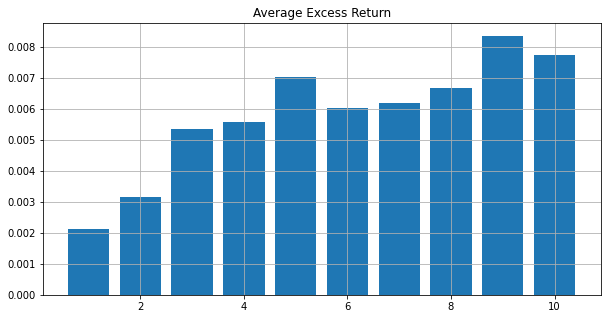

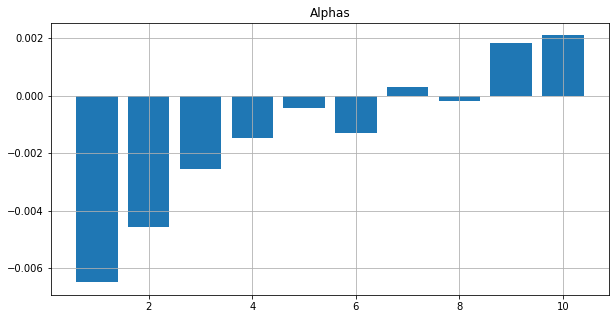

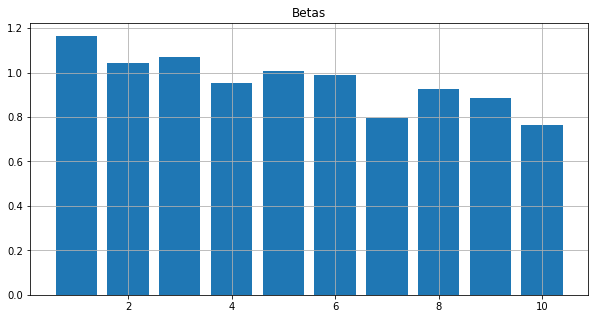

In [27]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Avg_Returns_VW )
plt.title("Average Excess Return")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Alphas_VW )
plt.title("Alphas")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Betas_VW )
plt.title("Betas")
plt.grid()

# Question c)



### Equally Weighted Portfolio
As we can see above, the average excess return is not correlated with the market capitalization for the equally weighted portfolio, since the values is always close to 1%.

We can see from the last question that the alphas are positive and significant for all deciles. Indeed, they represent between 15% and 45% of the excess premium for each decile. It means that the CAPM tend to undervalued the return of these stocks. Hence the CAPM does not explain the behavior of the stocks 

### Value Weightted Portfolio
As we can see above, the Average Excess Return is correlated to the market capitalization for value weighted porfolio. Since it increases when the market capitalization is increasing.

We can see from the last question that the alphas are stronlgy negative from decile 1 to 3 and positive from decile 9 to 10. For decile 4 to decile 8, the corresponding alpha are very close to zero. Then the CAPM explains well the return of the stocks for stocks with a market capitalization which are in decile 4 to 8. For the other decile, the alphas is like for the equally weighted case far from zero. For decile 9 and 10, the CAPM tends to undervaled the stocks. But for the 3 first decile the CAPM tends to overvalued the stocks. For these two case the CAPM does not explain well these stocks. However, CAPM results were better for the value weighted portfolio than for the equally weighted portfolio.

# Question d)

In [28]:
group1_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group2_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group3_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group4_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group5_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group6_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group7_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group8_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(33))
group9_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(32))
group10_list = pd.DataFrame(index =stocks_ret_matrix.index[1:], columns = np.arange(32))
for date in group1_list.index:
    temp =stocks_returns_raw_clean[stocks_returns_raw_clean["date"]==(date-1)]
    temp = temp.sort_values('Market Cap' , ascending = True)["permno"].to_numpy()
    group1_list.loc[date] = temp[:33]
    group2_list.loc[date] = temp[33:66]
    group3_list.loc[date] = temp[66:99]
    group4_list.loc[date] = temp[99:132]
    group5_list.loc[date] = temp[132:165]
    group6_list.loc[date] = temp[165:198]
    group7_list.loc[date] = temp[198:231]
    group8_list.loc[date] = temp[231:264]
    group9_list.loc[date] = temp[264:296]
    group10_list.loc[date] = temp[296:]
market_caps = stocks_returns_raw_clean.set_index("permno")

In [29]:
def equally_weighted_without_bias(group_list):
    #Begin by computing the return at each date
    Return = pd.DataFrame(index = risk_free.index[1:])
    ret = pd.DataFrame(index = risk_free.index[1:], columns = np.arange(group_list.shape[1]))
    for date in Return.index:
        ret.loc[date] = stocks_ret_matrix.loc[date,group_list.loc[date]].to_numpy()
    Return["Return"] = ret.mean(axis = 1)
    Return["Excess Return"] = Return["Return"] - stocks_ret_matrix["risk_free"]
    Return["Market Premium"] = stocks_ret_matrix["vwretd"] - stocks_ret_matrix["risk_free"]
    avg_ret = Return["Excess Return"].mean()
    model = sm.OLS(Return["Excess Return"] , sm.add_constant(Return["Market Premium"]) )
    results = model.fit()
    alpha = results.params["const"]
    beta = results.params["Market Premium"]
    return avg_ret,alpha,beta

In [30]:
def value_weighted_without_bias(group_list):
    #Begin by computing the return at each date
    Return = pd.DataFrame(index = risk_free.index[1:], columns = ["Return"],dtype=float)
    for date in tqdm(Return.index, desc = "compute vw retrun"):
        mkt_cap = market_caps.loc[group_list.loc[date]]
        mkt_cap = mkt_cap[mkt_cap["date"] == date-1]["Market Cap"]
        weight = mkt_cap / mkt_cap.sum()
        Return.loc[date, "Return"] = (stocks_ret_matrix.loc[date,group_list.loc[date]]* weight).sum()
    Return["Excess Return"] = Return["Return"] - stocks_ret_matrix["risk_free"][1:]
    Return["Market Premium"] = stocks_ret_matrix["vwretd"][1:] - stocks_ret_matrix["risk_free"][1:]
    avg_ret = Return["Excess Return"].mean()
    model = sm.OLS(Return["Excess Return"] , sm.add_constant(Return["Market Premium"]) )
    results = model.fit()
    results.summary()
    alpha = results.params["const"]
    beta = results.params["Market Premium"]    
    return avg_ret,alpha,beta

In [31]:
group_lists = [group1_list, group2_list, group3_list, group4_list, group5_list, group6_list, group7_list
              ,group8_list, group9_list, group10_list]
Avg_Returns_EW_without_bias = []
Avg_Returns_VW_without_bias = []
alpha_EW_without_bias = []
alpha_VW_without_bias = []
beta_EW_without_bias = []
beta_VW_without_bias = []

for group_list in tqdm(group_lists, desc = "group"):
    avg_ret, alpha, beta = equally_weighted_without_bias(group_list)
    Avg_Returns_EW_without_bias.append(avg_ret)
    alpha_EW_without_bias.append(alpha)
    beta_EW_without_bias.append(beta)
    avg_ret2,alpha2,beta2 = value_weighted_without_bias(group_list)
    Avg_Returns_VW_without_bias.append(avg_ret2)
    alpha_VW_without_bias.append(alpha2)
    beta_VW_without_bias.append(beta2)
    



group:   0%|          | 0/10 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

compute vw retrun:   0%|          | 0/383 [00:00<?, ?it/s]

# Equally Weighted Analysis

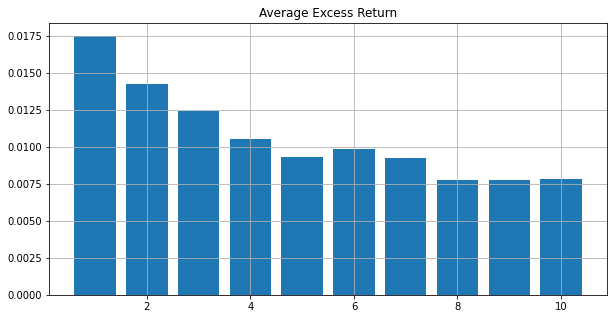

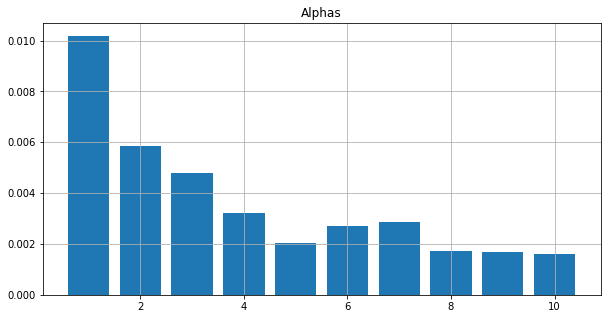

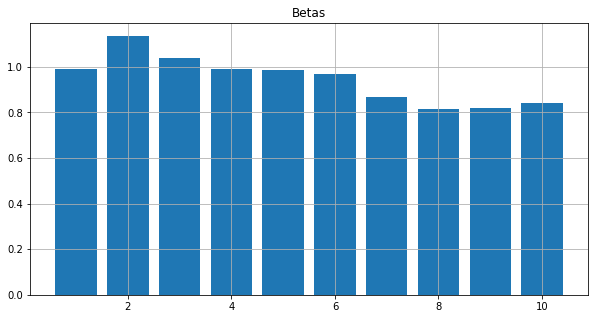

In [32]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Avg_Returns_EW_without_bias )
plt.title("Average Excess Return")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), alpha_EW_without_bias )
plt.title("Alphas")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), beta_EW_without_bias )
plt.title("Betas")
plt.grid()

As we can see on the figure above, the average excess premium is now negatively correlated to the market capitalization. In a sense, it is what we must expect since stocks with little market capitalization face liquidity premium. In order to put money on these stocks, we expect an higher average return.

For these portfolios, it seems that the lower is the market capitalization, the less the CAPM could explain the expected return since the alphas are bigger for smaller market capitalization. However, we can not say that the CAPM explain well the expected return of stocks with a high market capitalization since the alpha still correspond approximately to 25% of the expected return.

# Value Weighted Analysis

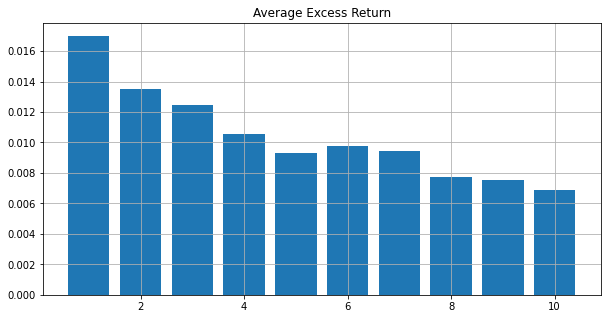

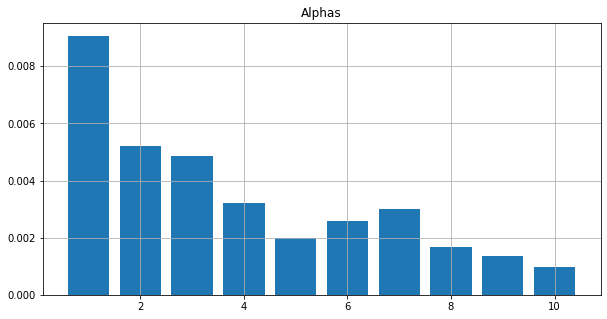

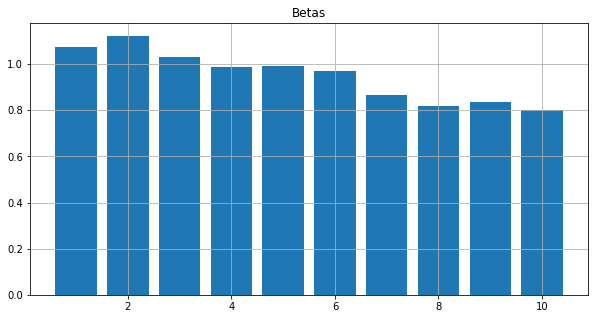

In [33]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), Avg_Returns_VW_without_bias )
plt.title("Average Excess Return")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), alpha_VW_without_bias )
plt.title("Alphas")
plt.grid()


plt.figure(figsize=(10,5))
plt.bar(np.arange(1,11), beta_VW_without_bias )
plt.title("Betas")
plt.grid()

As we can see on the figure above, the average excess premium is now negatively correlated to the market capitalization. In a sense, it is what we must expect since stocks with little market capitalization face liquidity premium. In order to put money on these stocks, we expect an higher average return.

For these portfolios, it seems that the lower is the market capitalization, the less the CAPM could explain the expected return since the alphas are bigger for smaller market capitalization. However, we can not say that the CAPM explain well the expected return of stocks with a high market capitalization since the alpha still correspond approximately to 15% of the expected return.

## Difference with "Look-ahead bias"

The Look ahead bias bring us information from big market capitaliation stocks performing well through the period considered as a all. With this method,some medium stocks at the begining of the period that have performing bad through the period will be present in the first deciles. On the other hand some medium stocks at the begining of the period that have performing very well will be present in the last deciles. Hence the average excess return of the highest market capitalization must be overvalued and the average excess return of the lowest market capitalization must be undervalued. This bias is what we have observed with the data in the first part of the exercise. The method implemented in the last question make sure to remove this bias since we are creating the decile based on the lags market capitalization.